In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [1]:
!pip install cdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 2.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=84c01c1e3551ace35529490e774c03cff608e3da1f45966ff6324677e1366f7b
  Stored in directory: /home/koppd/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29255 sha256=491959fa29a1f79d32ae47d3ea78476e16652c701b493a7e52f39016cc18f202
  Stored in directory: /home/koppd/.cache/pip/wheels/f3/a1/a2/a4a90339e8fe767416385d9aabc02ab731fa14d55ce7694a33
Successfully built GPUtil skrebate


In [2]:
# ok so, lets take the adult dataset 
# and then remove all features that 
# are not categorical
# include discritized age
# include educational-num???

In [3]:
from load_adult import EXPORTED_DATASET

In [4]:
preprocess_dataset, dataset, Y_VAR = EXPORTED_DATASET
preprop = preprocess_dataset(dataset)

/home/koppd/.conda/envs/tf2/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [5]:
print(dataset.columns)

Index(['age', 'workclass', 'education', 'educational-num', 'marital-status',
       'occupation', 'relationship', 'race', 'gender', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'income'],
      dtype='object')


In [6]:
# checkable_vars = [
#     # "workclass", 
#     # "marital-status", 
#     # "relationship", 
#     # "race"
#     # "gender", 
#     # "capital-gain", 
#     # "occupation",
#     # "capital-loss",
#     # "hours-per-week", 
#     # "native-country"
#     "age" # need to discritize, inhenent ordinality
#     ,"educational-num" # inherent ordinality
# ]

checkable_vars = [
    # "race", 
    "educational-num",
    # "admission_location", 
    # "insurance", 
    # "disease", 
    "age"
]

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
def train_test(features):
    
    Y = preprop[0][Y_VAR]
    X = preprop[0][np.concatenate([preprop[1][feature] for feature in features])]
    
    return train_test_split(X, Y, test_size=0.3)

def get_bal_acc(features, N_trials=20):
    X_train, X_test, y_train, y_test = train_test(features)
    ros = RandomOverSampler(sampling_strategy='minority')
    scores = []
    # for _ in range(N_trials):
        # model = LogisticRegression().fit(*ros.fit_resample(X_train, y_train))
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(balanced_accuracy_score(y_test, y_pred))
    return scores[0] 
    
scores = []
for x in checkable_vars:
    score = get_bal_acc(set(checkable_vars).difference([x]))
    scores.append(np.mean(score))
    print("std", np.std(score))
    

scores.append(np.mean(get_bal_acc(checkable_vars)))

data = pd.DataFrame({
    "feature": checkable_vars + ["None"],
    "score" : scores 
})
    
data

std 0.0
std 0.0


,feature,score
0,educational-num,0.500000
1,age,0.584556
2,None,0.654574


In [9]:
data.loc[data['feature'] != 'None','difference'] =  data[data['feature'] == "None"]['score'].values.flatten() - data[data['feature'] != 'None']['score']
data.sort_values(by='difference', ascending=False)

,feature,score,difference
0,educational-num,0.500000,0.154574
1,age,0.584556,0.070018
2,None,0.654574,NaN


In [10]:
group_1 =  ["educational-num"]#, "admission_location"]
group_2 = ["age"]#, "disease"]


In [11]:
def train_test(one_hot_vars, label_vars):
    
    Y = preprop[0][Y_VAR]

    if len(one_hot_vars) > 0:
        X = preprop[0][np.concatenate([preprop[1][feature] for feature in one_hot_vars])]
    else:
        X = None
        
    for feature in label_vars:
        if X is not None:
            X.loc[:,feature] = preprop[2][feature].copy()
        else:
            X = pd.DataFrame({feature: preprop[2][feature].copy()})
    
    return train_test_split(X.values, Y.values, test_size=0.3)

def label_vs_onehot(one_hot_vars, label_vars, N_trials=20):
    X_train, X_test, y_train, y_test = train_test(one_hot_vars, label_vars)
    ros = RandomOverSampler(sampling_strategy='minority')
    scores = []
    # for _ in range(N_trials):
        # model = LogisticRegression().fit(*ros.fit_resample(X_train, y_train))
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(balanced_accuracy_score(y_test, y_pred))
        
    print("OneHot:", one_hot_vars, "| Label:", label_vars, "|", np.mean(score))#, np.std(score) / N_trials)
    return scores[0]
    
# scores = []
# for x in checkable_vars:
#     # print(set(checkable_vars).difference([x]))
#     print("LEAVING OUT:", x)
# score = label_vs_onehot(group_1, group_2)
# score = label_vs_onehot(group_2, group_1)
    # scores.append(score)
    

# print("WITH ALL LABEL")
# label_vs_onehot([], checkable_vars)
# print("WITH ALL OH")
# _ = label_vs_onehot(checkable_vars, [])



In [12]:
# var1 = "age"
# var2 = "educational-num"

# X_train, X_test, Y_train, Y_test = train_test([], [var1, var2])
# # X_train, X_test, Y_train, Y_test = train_test([var1, var2], [])

# ones = Y_train == 1
# zeros = Y_train == 0
# # print(ones)
# # print(np.arange(len(ones))[ones])
# print(X_train[zeros])

# # plt.scatter(X_train[zeros,0], X_train[zeros,1], c="red", alpha=0.01)
# # plt.scatter(X_train[ones,0], X_train[ones,1], c="blue", alpha=0.01)

# x,y = X_train[:,0], X_train[:,1]
# xmin, xmax = min(x), max(x)
# ymin, ymax = min(y), max(y)


# xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
# positions = np.vstack([xx.ravel(), yy.ravel()])
# values = np.vstack([x, y])
# kernel = st.gaussian_kde(values)
# f = np.reshape(kernel(positions).T, xx.shape)

# fig = plt.figure()
# ax = fig.gca()
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# # Contourf plot
# cfset = ax.contourf(xx, yy, f, cmap='Blues')
# ## Or kernel density estimate plot instead of the contourf plot
# #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# # Contour plot
# cset = ax.contour(xx, yy, f, colors='k')
# # Label plot
# ax.clabel(cset, inline=1, fontsize=10)
# ax.set_xlabel('Y1')
# ax.set_ylabel('Y0')

# plt.show()


# # plt.scatter()

# IDEA:
Take existing ordinal format and make maximially randomized, analyze the result

In [13]:
feature_subset = [
    "age", 
    "race", 
    # "gender", 
    "native-country", 
    "hours-per-week", 
    "workclass", 
    "education", 
    "marital-status", 
    "occupation", 
    "relationship"
]


# X = dataset[feature_subset]
# y = dataset[Y_VAR]
X,_,y,_ = train_test([], feature_subset)

model = CatBoostClassifier()
model.fit(X, y)

importances = model.get_feature_importance(prettified=True)
importances


Learning rate set to 0.045043
0:	learn: 0.6549527	total: 71ms	remaining: 1m 10s
1:	learn: 0.6205583	total: 80.4ms	remaining: 40.1s
2:	learn: 0.5923842	total: 88.6ms	remaining: 29.5s
3:	learn: 0.5692862	total: 98.2ms	remaining: 24.5s
4:	learn: 0.5473546	total: 106ms	remaining: 21.1s
5:	learn: 0.5294029	total: 113ms	remaining: 18.7s
6:	learn: 0.5118110	total: 120ms	remaining: 17s
7:	learn: 0.4970348	total: 127ms	remaining: 15.8s
8:	learn: 0.4837398	total: 134ms	remaining: 14.8s
9:	learn: 0.4724925	total: 140ms	remaining: 13.8s
10:	learn: 0.4625065	total: 146ms	remaining: 13.1s
11:	learn: 0.4534016	total: 153ms	remaining: 12.6s
12:	learn: 0.4463812	total: 159ms	remaining: 12.1s
13:	learn: 0.4393027	total: 165ms	remaining: 11.6s
14:	learn: 0.4336536	total: 172ms	remaining: 11.3s
15:	learn: 0.4280421	total: 178ms	remaining: 11s
16:	learn: 0.4226156	total: 184ms	remaining: 10.6s
17:	learn: 0.4184823	total: 189ms	remaining: 10.3s
18:	learn: 0.4147189	total: 196ms	remaining: 10.1s
19:	learn: 0

,Feature Id,Importances
0,8,22.408710
1,7,18.481926
2,5,18.032268
3,0,15.226148
4,3,9.661492
5,6,5.812180
6,4,4.914310
7,1,2.854762
8,2,2.608204


In [14]:
[feature_subset[int(feature)] for feature, _ in importances.values]

['relationship',
 'occupation',
 'education',
 'age',
 'hours-per-week',
 'marital-status',
 'workclass',
 'race',
 'native-country']

In [15]:
data = []

models = list(zip(
    [
        "Logistic Regression", 
        "SVC (Linear)", 
        "SVC (RBF)", 
        "Random Forest"
    ],
    [
        LogisticRegression(solver = 'saga', fit_intercept = True, random_state = 42, n_jobs = 1),
        SVC(kernel = "linear", random_state = 42),
        SVC(kernel = "rbf", random_state = 42),
        RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = 1)
    ]
))

sorted_vars = [feature_subset[int(feature)] for feature, _ in importances.values]

for index in range(len(sorted_vars) + 1):
    one_hot_vars = sorted_vars[index:] # start with all 
    label_vars = sorted_vars[:index]
    X_train, X_test, y_train, y_test = train_test(one_hot_vars, label_vars)
    for model_name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = balanced_accuracy_score(y_test, y_pred)
        print(index, model_name, score)
        data.append({
            "model": model_name,
            "index": index,
            "bal_acc": score
        })
        
feature_encoding_incremental = pd.DataFrame(data)

feature_encoding_incremental

0 Logistic Regression 0.7448736200532113
0 SVC (Linear) 0.7466264348065402
0 SVC (RBF) 0.7286720998160945
0 Random Forest 0.7214929157223922


/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()


1 Logistic Regression 0.7361690669701957
1 SVC (Linear) 0.7395655008551392
1 SVC (RBF) 0.719943831902051
1 Random Forest 0.7264243586748474


/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()


2 Logistic Regression 0.7344471252106118
2 SVC (Linear) 0.7456294779758508
2 SVC (RBF) 0.7256599562150214
2 Random Forest 0.7364438691939892


/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

3 Logistic Regression 0.6994337126258017
3 SVC (Linear) 0.7026810913008391
3 SVC (RBF) 0.7107578176939566
3 Random Forest 0.7212025117464993


/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

4 Logistic Regression 0.673548524447683
4 SVC (Linear) 0.6576507047446809
4 SVC (RBF) 0.6650363675470672
4 Random Forest 0.7225295600631512


/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

5 Logistic Regression 0.6639339934400681
5 SVC (Linear) 0.6197657981500204
5 SVC (RBF) 0.6923810942563428
5 Random Forest 0.7264660460499814


/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

6 Logistic Regression 0.5843490746871575
6 SVC (Linear) 0.5289525553444282
6 SVC (RBF) 0.6438217742257066
6 Random Forest 0.7253660552164535


/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

7 Logistic Regression 0.5671485596418645
7 SVC (Linear) 0.5
7 SVC (RBF) 0.6524565278432033
7 Random Forest 0.7237914504734202
8 Logistic Regression 0.5679541955232659


/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,feature] = preprop[2][feature].copy()
/tmp/ipykernel_116853/155837439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

8 SVC (Linear) 0.5
8 SVC (RBF) 0.7079417958793373
8 Random Forest 0.7327619486618075
9 Logistic Regression 0.5688358502155673
9 SVC (Linear) 0.5
9 SVC (RBF) 0.7053802993602521
9 Random Forest 0.7329942978999583


,model,index,bal_acc
0,Logistic Regression,0,0.744874
1,SVC (Linear),0,0.746626
2,SVC (RBF),0,0.728672
3,Random Forest,0,0.721493
4,Logistic Regression,1,0.736169
5,SVC (Linear),1,0.739566
6,SVC (RBF),1,0.719944
7,Random Forest,1,0.726424
8,Logistic Regression,2,0.734447
9,SVC (Linear),2,0.745629


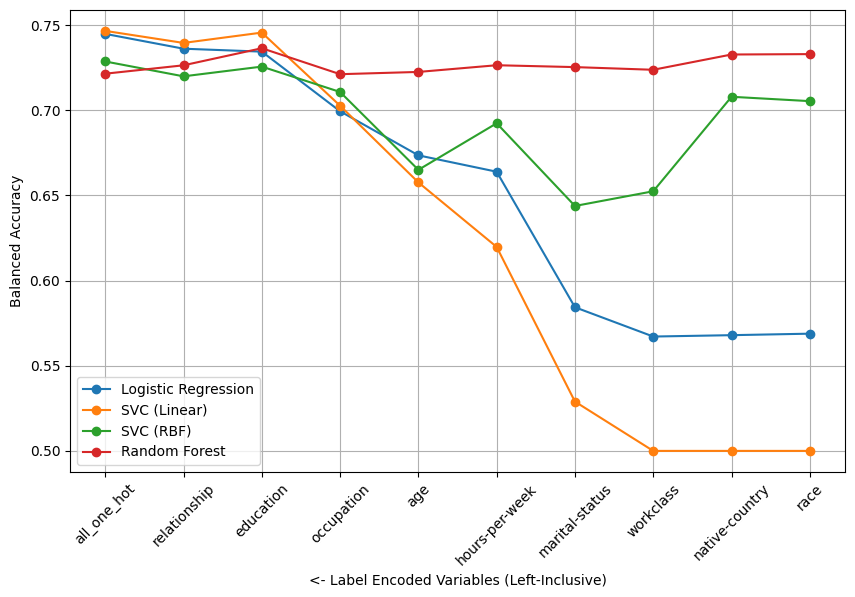

In [16]:
plt.figure(figsize=(10, 6))

df = feature_encoding_incremental

for model in df['model'].unique():
    model_df = df[df['model'] == model]
    plt.plot(model_df['index'], model_df['bal_acc'], label=model, marker='o')

plt.xlabel('<- Label Encoded Variables (Left-Inclusive)')
plt.ylabel('Balanced Accuracy')
# plt.title('Model Score Comparison')
plt.xticks(ticks=range(len(sorted_vars)+1), labels=["all_one_hot"] + sorted_vars, rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Goals

- Test causal relationships to infer predictivity of variables
- Test variable ordinal ordering to find
    1. Maximially suboptimial ordering
    2. Random orderings
    3. Optimal orderings


4 Phases

1 phase per day


Today we will implement the maximally suboptimal ordering